<a href="https://colab.research.google.com/github/karube044/100/blob/master/8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 準備
# google colaboratoryでGPUを使用するために最初にランタイムのタイプをGPUに変更する
# 問50で構築した3つのデータファイルはgoogle colaboratoryにアップロードしておく
# それぞれのファイルを読み込んでおく(headerあり)
import pandas as pd
train = pd.read_csv('train.txt', header=0, sep='\t')
valid = pd.read_csv('valid.txt', header=0, sep='\t')
test = pd.read_csv('test.txt', header=0, sep='\t')

# 問60の単語ベクトルはもう一度ここでダウンロードする
FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt
# 問60と同じように単語ベクトルを使用できるようにしておく
from gensim.models import KeyedVectors
model_vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [17]:
# 70. 単語ベクトルの和による特徴量
# PyTorchをインポートしておく
import torch
import string

# 特徴量を求めるための関数の作成
def feature_avg(text):
  # 記事見出し(text)から単語のリストを獲得する

  # translateで記号をスペースに置換するようにする(削除では単語が連結される可能性があるため)
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)

  # スペースで分割して単語を獲得する
  words = text.split() 
  # 単語ベクトルからその単語のベクトル表現を獲得(単語ベクトルに存在する単語のみ)
  vec = [model_vec[word] for word in words if word in model_vec] 
  # 一つの記事見出しの特徴量は、そこに含まれる単語ベクトルの平均
  # tensor型の配列とする
  return torch.tensor(sum(vec) / len(vec)) 

In [18]:
# それぞれのデータの特徴量の行列を作成する(stackでベクトルのバッチを作成する)
X_train = torch.stack([feature_avg(text) for text in train['TITLE']])
X_valid = torch.stack([feature_avg(text) for text in valid['TITLE']])
X_test = torch.stack([feature_avg(text) for text in test['TITLE']])
# 確認
print(X_train.size())
print(X_train)

torch.Size([10672, 300])
tensor([[-0.1400,  0.0522, -0.0721,  ...,  0.0303,  0.0224, -0.0816],
        [-0.0785, -0.0280,  0.0040,  ...,  0.1154,  0.0537, -0.0167],
        [-0.0552, -0.0524,  0.1040,  ...,  0.0014,  0.1029, -0.0172],
        ...,
        [ 0.1370,  0.0423,  0.0329,  ...,  0.0284,  0.0161, -0.0109],
        [-0.0120,  0.0574,  0.0088,  ...,  0.0693,  0.1407,  0.0544],
        [ 0.0375,  0.0493, -0.0067,  ...,  0.0785,  0.0856,  0.0517]])


In [19]:
# 記事のカテゴリ名をラベルに変更するための辞書
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
# map関数を用いて、各記事のカテゴリからラベルのベクトルを作成する
Y_train = torch.tensor(list(map(lambda x: category_dict[x], train['CATEGORY'])))
Y_valid = torch.tensor(list(map(lambda x: category_dict[x], valid['CATEGORY'])))
Y_test = torch.tensor(list(map(lambda x: category_dict[x], test['CATEGORY'])))
# 確認
print('訓練データラベル')
print(Y_train.size())
print(Y_train)

訓練データラベル
torch.Size([10672])
tensor([0, 0, 2,  ..., 0, 0, 2])


In [20]:
# PyTorchファイルの保存(.pt拡張子)
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(Y_train, 'Y_train.pt')
torch.save(Y_valid, 'Y_valid.pt')
torch.save(Y_test, 'Y_test.pt')

In [21]:
# 71. 単層ニューラルネットワークによる予測
# 一応先ほど作成したファイルから読み込み
xtrain = torch.load('X_train.pt')
xvalid = torch.load('X_valid.pt')
xtest = torch.load('X_test.pt')
ytrain = torch.load('Y_train.pt')
yvalid = torch.load('Y_valid.pt')
ytest = torch.load('Y_test.pt')

In [22]:
# 標準的に必要となるライブラリ
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [23]:
# モデルの設定
class Nlp71(nn.Module):
  def __init__(self):
    super(Nlp71, self).__init__()
    # 単層(layer:レイヤー)を定義
    # 一つの単語ベクトルは300次元で、ラベルが４,バイアス項はなし
    self.l1=nn.Linear(300,4, bias=False)
    # 今回は重みをランダムな値で(正規分布により)初期化する
    nn.init.normal_(self.l1.weight, 0.0, 1.0) 
        
  # 順方向の計算
  def forward(self,x):
    # ソフトマックス関数を適用する(dim=-1で行のsoftmaxを指定)
    h1 = torch.softmax(self.l1(x), dim=-1)
    return h1

In [24]:
# モデルのインスタンス作成
model = Nlp71()
# y1ハット(事例x1の予測)を求める
y1_hat=model(xtrain[:1])
print(y1_hat)

tensor([[0.1170, 0.2381, 0.0695, 0.5754]], grad_fn=<SoftmaxBackward>)


In [25]:
# Yハット(x1~x4までの予測)を求める
Y_hat = model(xtrain[:4])
print(Y_hat)

tensor([[0.1170, 0.2381, 0.0695, 0.5754],
        [0.2908, 0.1296, 0.4754, 0.1042],
        [0.1781, 0.4636, 0.1318, 0.2265],
        [0.0373, 0.7474, 0.1613, 0.0539]], grad_fn=<SoftmaxBackward>)


In [26]:
# 72. 損失と勾配の計算
# 損失関数の設定（クロスエントロピー損失）
criterion = nn.CrossEntropyLoss()

In [27]:
# y1ハット(事例x1)に対する損失を求める
loss_y1 = criterion(y1_hat, ytrain[:1])
# 次に重みに対しての勾配を求める
# 勾配をzero_grad()で初期化してからbackward()で求める
model.zero_grad()
loss_y1.backward()
print('損失：', loss_y1.item())
print('勾配：', model.l1.weight.grad)

損失： 1.5398969650268555
勾配： tensor([[ 1.5726e-02, -5.8687e-03,  8.1061e-03,  ..., -3.4050e-03,
         -2.5134e-03,  9.1725e-03],
        [-2.2302e-03,  8.3226e-04, -1.1495e-03,  ...,  4.8287e-04,
          3.5644e-04, -1.3008e-03],
        [-2.8570e-04,  1.0662e-04, -1.4727e-04,  ...,  6.1859e-05,
          4.5663e-05, -1.6664e-04],
        [-1.3210e-02,  4.9298e-03, -6.8093e-03,  ...,  2.8602e-03,
          2.1113e-03, -7.7051e-03]])


In [28]:
# Yハット(事例x1~x4)に対する損失を求める
loss_Y = criterion(Y_hat, ytrain[:4])
model.zero_grad()
loss_Y.backward()
print('損失：', loss_Y.item())
print('勾配：', model.l1.weight.grad)

損失： 1.5137498378753662
勾配： tensor([[ 8.7013e-03, -1.0284e-03,  1.3730e-03,  ..., -6.7144e-03,
         -3.3870e-03,  3.3764e-03],
        [-3.5618e-03,  1.7197e-04,  3.1312e-03,  ...,  7.2221e-04,
          3.0929e-03, -1.2069e-03],
        [-1.1572e-03,  2.2852e-04, -3.3255e-03,  ...,  4.5412e-03,
         -1.1259e-03, -7.8721e-05],
        [-3.9823e-03,  6.2794e-04, -1.1787e-03,  ...,  1.4511e-03,
          1.4200e-03, -2.0908e-03]])


In [29]:
# 73. 確率的勾配降下法による学習
# モデルの設定
class Nlp73(nn.Module):
  def __init__(self):
    super(Nlp73, self).__init__()
    self.l1=nn.Linear(300,4, bias=False)
    # 今回は学習するので初期化は省略
        
  # 順方向の計算
  def forward(self,x):
    h1 = torch.softmax(self.l1(x), dim=-1)
    return h1

In [30]:
# 損失、モデルのインスタンス、最適化関数の設定
criterion = nn.CrossEntropyLoss()
model = Nlp73()
# 最適化関数はSGDを用いる。学習率は試行錯誤(今回は0.1とした)
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [31]:
# 学習の開始
model.train()
# 100エポックで終了とする
for ep in range(100):
  # ミニバッチ化はこの問題では行わないのでバッチ処理となる
  output = model(xtrain) # 順方向の計算
  loss = criterion(output, ytrain) # 順方向の出力と教師信号から誤差を得る
  optimizer.zero_grad() # 勾配(微分値)を初期化(必要)
  loss.backward() # 損失関数に対する変数(パラメータ)の微分値を求める
  optimizer.step() # optimizerに設定されたパラメータを更新

In [32]:
# 74. 正解率の計測
# テスト実行
model.eval()
with torch.no_grad():
  # 順方向による出力
  output_train = model(xtrain)
  output_test = model(xtest)
  # 各データの出力値の最も高いラベル(予測ラベル)を1次元配列で取得する
  ans_train = torch.argmax(output_train,1)
  ans_test = torch.argmax(output_test,1)
  # 正解ラベルと予測ラベルをもとに正解率を出力
  print('学習データの正解率：',((ytrain == ans_train).sum().float() / len(ans_train)).item())
  print('評価データの正解率：',((ytest == ans_test).sum().float() / len(ans_test)).item())

学習データの正解率： 0.7738006114959717
評価データの正解率： 0.7623687982559204


In [33]:
# 75. 損失と正解率のプロット
# モデルの設定~最適化関数までは同じ(モデルの名前だけ変更)
class Nlp75(nn.Module):
  def __init__(self):
    super(Nlp75, self).__init__()
    self.l1=nn.Linear(300,4, bias=False)
        
  def forward(self,x):
    h1 = torch.softmax(self.l1(x), dim=-1)
    return h1

In [34]:
# 正解率と損失の計算のための関数
def cal_loss_accuracy(model, criterion, X, Y):
  model.eval()
  with torch.no_grad():
    # 順方向による出力
    output = model(X)
    # 損失の計算
    loss = criterion(output, Y).item()
    # 正解率の計算
    ans = torch.argmax(output,1)
    accuracy = ((Y == ans).sum().float() / len(ans)).item()

  return loss, accuracy

In [35]:
# モデルのインスタンス、損失関数、最適化関数の設定
criterion = nn.CrossEntropyLoss()
model = Nlp75()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# 学習の開始
model.train()
log_train = []
log_valid = []

# 100エポックで終了とする(学習の進め方は同じ)
for ep in range(100):
  output = model(xtrain)
  loss = criterion(output, ytrain)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # グラフにプロットするための損失と正解率の算出
  loss_train, accuracy_train = cal_loss_accuracy(model, criterion, xtrain, ytrain)
  loss_valid, accuracy_valid = cal_loss_accuracy(model, criterion, xvalid, yvalid)
  log_train.append([loss_train, accuracy_train])
  log_valid.append([loss_valid, accuracy_valid])

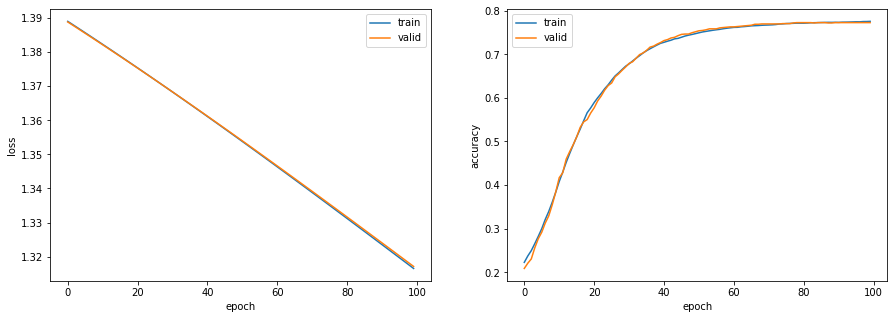

In [36]:
# グラフの描写
# 動的(エポックごと)に表示ができなかったので、すべての計算が終わったのちに表示する
from matplotlib import pyplot as plt

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [37]:
# 76. チェックポイント
# モデルの設定
class Nlp76(nn.Module):
  def __init__(self):
    super(Nlp76, self).__init__()
    self.l1=nn.Linear(300,4, bias=False)
  
  def forward(self,x):
    h1 = torch.softmax(self.l1(x), dim=-1)
    return h1

In [38]:
# モデルのインスタンス、損失関数、最適化関数の設定
criterion = nn.CrossEntropyLoss()
model = Nlp76()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# 学習の開始
# 今回はチェックポイントをファイルに書き出すことが目的のため
# 正解率損失の計算、プロットは省略する
model.train()

# 30エポックで終了とする(ファイル数を少なくするため)
for ep in range(30):
  output = model(xtrain) 
  loss = criterion(output, ytrain) 
  optimizer.zero_grad()
  loss.backward() 
  optimizer.step() 

  # パラメータの値はmodel.state_dict()で確認可能
  # 最適化アルゴリズムの内部状態も同じくoptimizer.state_dict()
  f_name='checkpoint' + str(ep) +'.pt'

  # チェックポイントの保存
  torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, f_name)

In [39]:
# 77. ミニバッチ化
# モデルの設定
class Nlp77(nn.Module):
  def __init__(self):
    super(Nlp77, self).__init__()
    self.l1=nn.Linear(300,4, bias=False)

  def forward(self,x):
    h1 = torch.softmax(self.l1(x), dim=-1)
    return h1

In [40]:
# テストデータの正解率計算のための関数
def cal_test_accuracy77(model):
  model.eval()
  with torch.no_grad():
    # 順方向による出力
    output = model(xtest)
    # 正解率の計算
    ans = torch.argmax(output,1)
    accuracy = ((ytest == ans).sum().float() / len(ans)).item()

  return accuracy

In [41]:
# 今回は各バッチサイズごとの処理時間とテストデータの正解率を出力するようにする
# 時間計測のためtimeをインポートする
import time

# 学習の関数
def model_train77(n, bs):
  # モデルのインスタンス、損失関数、最適化関数の設定
  # 各バッヂごとに初期化する
  criterion = nn.CrossEntropyLoss()
  model = Nlp77()
  optimizer = optim.SGD(model.parameters(), lr=0.1)

  # 学習の開始
  model.train()
  # 30エポックで終了とする
  for ep in range(30):
    # 開始時間の計測
    s_time = time.time()

    # permutationにより数値をシャッフル
    idx = np.random.permutation(n)

    # 訓練データをバッチサイズごとに刻んでいく
    for i in range(0, n, bs):
      # バッチサイズ分のデータを取得する
      xtm = xtrain[idx[i:(i+bs) if (i+bs) < n else n]]
      ytm = ytrain[idx[i:(i+bs) if (i+bs) < n else n]]
      output = model(xtm) 
      loss = criterion(output, ytm) 
      optimizer.zero_grad()
      loss.backward() 
      optimizer.step()

    # 1エポックの終了時間の計測
    e_time = time.time()
    # 最終エポックの学習にかかった時間を表示する
    if ep == 0:
      print('バッチサイズ：',bs,'処理時間：', e_time - s_time)
  
  print('accuracy：', cal_test_accuracy77(model))

In [42]:
# 実行
# データサイズ
n = len(xtrain)
# バッチサイズ(1~8までとしておく)
bs_list = [1, 2, 4, 8]
# バッチサイズを変更するたびに初期化するために関数を使用した
for bs in bs_list:
  model_train77(n, bs)

バッチサイズ： 1 処理時間： 2.2152798175811768
accuracy： 0.9062968492507935
バッチサイズ： 2 処理時間： 1.2101922035217285
accuracy： 0.8965517282485962
バッチサイズ： 4 処理時間： 0.6124587059020996
accuracy： 0.8905547261238098
バッチサイズ： 8 処理時間： 0.3123960494995117
accuracy： 0.8665667176246643


In [43]:
# 78. GPU上での学習
# モデルの設定(77からの流用)
class Nlp78(nn.Module):
  def __init__(self):
    super(Nlp78, self).__init__()
    self.l1=nn.Linear(300,4, bias=False)

  def forward(self,x):
    h1 = torch.softmax(self.l1(x), dim=-1)
    return h1

In [44]:
# GPUに送るためのコード
device = torch.device("cuda:0" 
                     if torch.cuda.is_available()
                     else "cpu") 

In [45]:
# GPUを使用するために入力TensorをGPUに送る
xtrain_gpu = xtrain.to(device)
xvalid_gpu = xvalid.to(device)
xtest_gpu = xtest.to(device)
ytrain_gpu = ytrain.to(device)
yvalid_gpu = yvalid.to(device)
ytest_gpu = ytest.to(device)

In [46]:
# テストデータの正解率計算のための関数(77からの流用)
def cal_test_accuracy78(model):
  model.eval()
  with torch.no_grad():
    output = model(xtest_gpu)
    ans = torch.argmax(output,1)
    accuracy = ((ytest_gpu == ans).sum().float() / len(ans)).item()

  return accuracy

In [47]:
# 学習の関数(77からの流用)
def model_train78(n, bs):

  criterion = nn.CrossEntropyLoss()
  # モデルのインスタンス作成時にGPUに移動させる
  model = Nlp78().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.1)

  # 学習の開始(使うデータはGPUに移動したものを使用)
  model.train()
  for ep in range(30):
    s_time = time.time()
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
      xtm = xtrain_gpu[idx[i:(i+bs) if (i+bs) < n else n]]
      ytm = ytrain_gpu[idx[i:(i+bs) if (i+bs) < n else n]]
      output = model(xtm) 
      loss = criterion(output, ytm) 
      optimizer.zero_grad()
      loss.backward() 
      optimizer.step()
    e_time = time.time()
    if ep == 0:
      print('バッチサイズ：',bs,'処理時間：', e_time - s_time)
  print('accuracy：', cal_test_accuracy78(model))

In [48]:
# 実行
# 今回用いたGPUは自分のPCの内臓GPUなので性能が低いのだと思われる
n = len(xtrain_gpu)
bs_list = [1, 2, 4, 8]
for bs in bs_list:
  model_train78(n, bs)

バッチサイズ： 1 処理時間： 6.18485164642334
accuracy： 0.9032983779907227
バッチサイズ： 2 処理時間： 3.0080318450927734
accuracy： 0.9017991423606873
バッチサイズ： 4 処理時間： 1.5457637310028076
accuracy： 0.8898051381111145
バッチサイズ： 8 処理時間： 0.7735369205474854
accuracy： 0.8688156008720398


In [49]:
# 79. 多層ニューラルネットワーク
# モデルの設定
class Nlp79(nn.Module):
  def __init__(self):
    super(Nlp79, self).__init__()
    self.l1=nn.Linear(300,4)

  def forward(self,x):
    h1 = torch.softmax(self.l1(x), dim=-1)
    return h1

In [50]:
# テストデータの正解率計算のための関数
def cal_test_accuracy79(model):
  model.eval()
  with torch.no_grad():
    # 順方向による出力
    output = model(xtest)
    # 正解率の計算
    ans = torch.argmax(output,1)
    accuracy = ((ytest == ans).sum().float() / len(ans)).item()

  return accuracy

In [51]:
# モデルのインスタンス、損失関数、最適化関数の設定
# 各バッヂごとに初期化する
criterion = nn.CrossEntropyLoss()
model = Nlp79()
optimizer = optim.SGD(model.parameters(), lr=0.1)

n = len(xtrain)
bs = 1

# 学習の開始
model.train()
# 30エポックで終了とする
for ep in range(100):


  # permutationにより数値をシャッフル
  idx = np.random.permutation(n)

  # 訓練データをバッチサイズごとに刻んでいく
  for i in range(0, n, bs):
    # バッチサイズ分のデータを取得する
    xtm = xtrain[idx[i:(i+bs) if (i+bs) < n else n]]
    ytm = ytrain[idx[i:(i+bs) if (i+bs) < n else n]]
    output = model(xtm) 
    loss = criterion(output, ytm) 
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()


print('accuracy：', cal_test_accuracy79(model))

accuracy： 0.9107946157455444
